In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from PIL import Image
import os
from pathlib import Path
from keras.preprocessing import image
import logging





# Function to preprocess categorical variables
def preprocess_categorical_variables(age, gender):
    gender_encoder = LabelEncoder()
    gender_encoded = gender_encoder.fit_transform([gender])
    return age, gender_encoded[0]

# Function to preprocess income level
def preprocess_income_level(income_level):
    income_map = {'low': 0, 'middle': 1, 'high': 2}
    return income_map.get(income_level.lower(), 0)

# Function to preprocess age
def preprocess_age(age):
    if pd.isnull(age):  # Check for missing values
        return None
    elif isinstance(age, str):  # Handle age ranges
        try:
            age_split = age.split(' - ')
            start_age = int(age_split[0])
            end_age = int(age_split[1])
            average_age = (start_age + end_age) / 2
            return average_age
        except (ValueError, IndexError) as e:
            logging.error(f"Error processing age '{age}': {str(e)}")
            return None
    else:  # Handle float values
        return age

# Function to encode gender variable
def preprocess_gender(gender):
    gender_encoder = LabelEncoder()
    gender_encoded = gender_encoder.fit_transform([gender])
    return gender_encoded[0]

import os
import re

import os

from PIL import Image
import numpy as np
import os
import logging

from PIL import Image
import numpy as np
import os
import logging

# Function to preprocess image
def preprocess_image(image_path, target_size=(64,64)):
    try:
        with open(image_path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')  # Convert to RGB format if image has an alpha channel
            img = img.resize(target_size)
            image_array = np.array(img) / 255.0
            return image_array
    except Exception as e:
        logging.error(f"Error preprocessing image from {image_path}: {str(e)}")
        return None

# Function to preprocess images
def preprocess_images(image_paths, num_images_per_category, target_size=(64, 64)):
    images = []
    for path in image_paths:
        # Check if file exists
        if os.path.exists(path):
            # Truncate file name if it's too long
            truncated_path = path[:255]  # Limiting to 255 characters
            if truncated_path != path:
                logging.warning(f"Truncated file path: {path} to {truncated_path}")
            img = preprocess_image(truncated_path, target_size)
            if img is not None:
                images.append(img)
        else:
            logging.error(f"File not found: {path}")
    return images







# Function to preprocess data from CSV file and perform KMeans clustering
def preprocess_data(csv_file, num_clusters=9, num_images_per_category=3):
    csv_dir = Path(csv_file).parent
    os.chdir(csv_dir)

    # Read data from CSV file
    data = pd.read_csv(csv_file)

    # Preprocess each row in the CSV file
    preprocessed_data = []
    feature_matrix = []
    for index, row in data.iterrows():
        age = preprocess_age(row['Age'])
        gender = preprocess_gender(row['Gender'])
        income_level = row['IncomeLevel']
        color_image_paths = str(row['Color']).split(',')
        decor_image_paths = str(row['Decor']).split(',')
        lightning_image_paths = str(row['Lightning']).split(',')
        furniture_image_paths = str(row['Furniture']).split(',')
        styling_image_paths = str(row['StylingStation']).split(',')
        washing_image_paths = str(row['WashingStation']).split(',')
        waiting_image_paths = str(row['WaitingArea']).split(',')

        # Remove leading/trailing spaces from file paths
        styling_image_paths = [path.strip() for path in styling_image_paths]
        washing_image_paths = [path.strip() for path in washing_image_paths]

        # Preprocess images for each category
        color_images = preprocess_images(color_image_paths, num_images_per_category)
        decor_images = preprocess_images(decor_image_paths, num_images_per_category)
        lightning_images = preprocess_images(lightning_image_paths, num_images_per_category)
        furniture_images = preprocess_images(furniture_image_paths, num_images_per_category)
        styling_images = preprocess_images(styling_image_paths, num_images_per_category)
        washing_images = preprocess_images(washing_image_paths, num_images_per_category)
        waiting_images = preprocess_images(waiting_image_paths, num_images_per_category)

        # Preprocess income level
        income_encoded = preprocess_income_level(income_level)

        # Append features to feature matrix for clustering
        feature_vector = [age, gender, income_encoded]
        feature_matrix.append(feature_vector)

        preprocessed_data.append({
            'Age': age,
            'Gender': gender,
            'IncomeLevel': income_encoded,
            'Color': color_images,
            'Decor': decor_images,
            'Lightning': lightning_images,
            'Furniture': furniture_images,
            'StylingStation': styling_images,
            'WashingStation': washing_images,
            'WaitingArea': waiting_images
        })

    # Apply clustering to feature matrix
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    # Add cluster labels to preprocessed data
    for i, cluster_label in enumerate(cluster_labels):
        preprocessed_data[i]['Cluster'] = cluster_label

    return preprocessed_data


# Example usage:
csv_file = "/content/drive/MyDrive/Final Research/salondataset.csv"
num_clusters =9

# Preprocess data from CSV file
preprocessed_data = preprocess_data(csv_file)

# Save the dataset with cluster labels
data_with_clusters = pd.DataFrame(preprocessed_data)
data_with_clusters.to_csv("/content/drive/MyDrive/Final Research/PP2_Preprocess_Final_dataset(9).csv", index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Layer

# Custom layer for self-attention
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        attention_weights = tf.keras.layers.Softmax(axis=-1)(inputs)
        attention_output = inputs * attention_weights
        return attention_output

    def compute_output_shape(self, input_shape):
        return input_shape

# Assuming preprocessed_data is a list of dictionaries
X_color = np.array([np.array(item['Color']) for item in preprocessed_data])
X_decor = np.array([np.array(item['Decor']) for item in preprocessed_data])
X_lightning = np.array([np.array(item['Lightning']) for item in preprocessed_data])
X_furniture = np.array([np.array(item['Furniture']) for item in preprocessed_data])
X_styling = np.array([np.array(item['StylingStation']) for item in preprocessed_data])
X_washing = np.array([np.array(item['WashingStation']) for item in preprocessed_data])
X_waiting = np.array([np.array(item['WaitingArea']) for item in preprocessed_data])
age = np.array([item['Age'] for item in preprocessed_data])
gender = np.array([item['Gender'] for item in preprocessed_data])
income_level = np.array([item['IncomeLevel'] for item in preprocessed_data])
y = np.array([item['Cluster'] for item in preprocessed_data])

# Remove the unnecessary dimension for image arrays
X_color = X_color.squeeze(axis=1)
X_decor = X_decor.squeeze(axis=1)
X_lightning = X_lightning.squeeze(axis=1)
X_furniture = X_furniture.squeeze(axis=1)
X_styling = X_styling.squeeze(axis=1)
X_washing = X_washing.squeeze(axis=1)
X_waiting = X_waiting.squeeze(axis=1)

# Split the data into training and testing sets
(X_color_train, X_color_test,
 X_decor_train, X_decor_test,
 X_lightning_train, X_lightning_test,
 X_furniture_train, X_furniture_test,
 X_styling_train, X_styling_test,
 X_washing_train, X_washing_test,
 X_waiting_train, X_waiting_test,
 age_train, age_test,
 gender_train, gender_test,
 income_train, income_test,
 y_train, y_test) = train_test_split(X_color, X_decor, X_lightning, X_furniture, X_styling, X_washing, X_waiting, age, gender, income_level, y, test_size=0.2, random_state=42)

# Define input layers
input_color = Input(shape=(64, 64, 3))
input_decor = Input(shape=(64, 64, 3))
input_lightning = Input(shape=(64, 64, 3))
input_furniture = Input(shape=(64, 64, 3))
input_styling = Input(shape=(64, 64, 3))
input_washing = Input(shape=(64, 64, 3))
input_waiting = Input(shape=(64, 64, 3))
input_age = Input(shape=(1,))
input_gender = Input(shape=(1,))
input_income = Input(shape=(1,))

# CNN layers for each input branch
def convolutional_layers(input_layer):
    conv = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    conv = MaxPooling2D((2, 2))(conv)
    conv = BatchNormalization()(conv)
    conv = Dropout(0.3)(conv)
    return conv

conv_color = convolutional_layers(input_color)
conv_decor = convolutional_layers(input_decor)
conv_lightning = convolutional_layers(input_lightning)
conv_furniture = convolutional_layers(input_furniture)
conv_styling = convolutional_layers(input_styling)
conv_washing = convolutional_layers(input_washing)
conv_waiting = convolutional_layers(input_waiting)

# Apply attention mechanisms to image branches
attention_color = SelfAttention()(conv_color)
attention_decor = SelfAttention()(conv_decor)
attention_lightning = SelfAttention()(conv_lightning)
attention_furniture = SelfAttention()(conv_furniture)
attention_styling = SelfAttention()(conv_styling)
attention_washing = SelfAttention()(conv_washing)
attention_waiting = SelfAttention()(conv_waiting)

# Flatten each branch
def flatten_layer(conv_layer):
    flatten = Flatten()(conv_layer)
    return flatten

flatten_color = flatten_layer(attention_color)
flatten_decor = flatten_layer(attention_decor)
flatten_lightning = flatten_layer(attention_lightning)
flatten_furniture = flatten_layer(attention_furniture)
flatten_styling = flatten_layer(attention_styling)
flatten_washing = flatten_layer(attention_washing)
flatten_waiting = flatten_layer(attention_waiting)

# Demographic branches
dense_age = Dense(8, activation='relu')(input_age)
dense_gender = Dense(8, activation='relu')(input_gender)
dense_income = Dense(8, activation='relu')(input_income)

# Concatenate attention outputs
merged_with_attention = concatenate([flatten_color, flatten_decor, flatten_lightning, flatten_furniture, flatten_styling, flatten_washing, flatten_waiting,
                                     dense_age, dense_gender, dense_income])

# Dense layers for classification
dense1_with_attention = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(merged_with_attention)
dropout1_with_attention = Dropout(0.6)(dense1_with_attention)
output_with_attention = Dense(num_clusters, activation='softmax')(dropout1_with_attention)

# Define the model with attention mechanisms
model_with_attention = Model(inputs=[input_color, input_decor, input_lightning, input_furniture, input_styling, input_washing, input_waiting,
                                      input_age, input_gender, input_income], outputs=output_with_attention)

# Compile the model
optimizer = Adam(learning_rate=0.0001,clipnorm=1.0)  # Adjusted learning rate
model_with_attention.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Reduced patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)  # Adjusted parameterse

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Train the model with attention mechanisms
history_with_attention = model_with_attention.fit(
    [X_color_train, X_decor_train, X_lightning_train, X_furniture_train, X_styling_train, X_washing_train, X_waiting_train, age_train, gender_train, income_train],
    y_train,
    epochs=100,
    batch_size=128,  # Adjusted batch size
    validation_data=(
        [X_color_test, X_decor_test, X_lightning_test, X_furniture_test, X_styling_test, X_washing_test, X_waiting_test, age_test, gender_test, income_test],
        y_test
    ),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model with attention mechanisms
loss_with_attention, accuracy_with_attention = model_with_attention.evaluate(
    [X_color_test, X_decor_test, X_lightning_test, X_furniture_test, X_styling_test, X_washing_test, X_waiting_test, age_test, gender_test, income_test], y_test)
print(f'Test Loss (with attention): {loss_with_attention}, Test Accuracy (with attention): {accuracy_with_attention}')

# Print accuracy
print("Training Accuracy (with attention):", history_with_attention.history['accuracy'][-1])
print("Validation Accuracy (with attention):", history_with_attention.history['val_accuracy'][-1])


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.1937 - loss: 2.3542 - val_accuracy: 0.4271 - val_loss: 2.2784 - learning_rate: 1.0000e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4409 - loss: 1.7541 - val_accuracy: 0.4271 - val_loss: 2.2689 - learning_rate: 1.0000e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.5716 - loss: 1.4521 - val_accuracy: 0.4271 - val_loss: 2.2655 - learning_rate: 1.0000e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.6435 - loss: 1.2457 - val_accuracy: 0.4271 - val_loss: 2.2353 - learning_rate: 1.0000e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.6947 - loss: 1.1405 - val_accuracy: 0.4479 - val_loss: 2.1955 - learning_rate: 1.0000e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - accuracy: 0.7153 - loss: 1.0247 - val_accuracy: 0.4479 - val_loss: 2.1689 - learning_rate: 1.0000e-04
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 0.7526 - loss: 0.9250

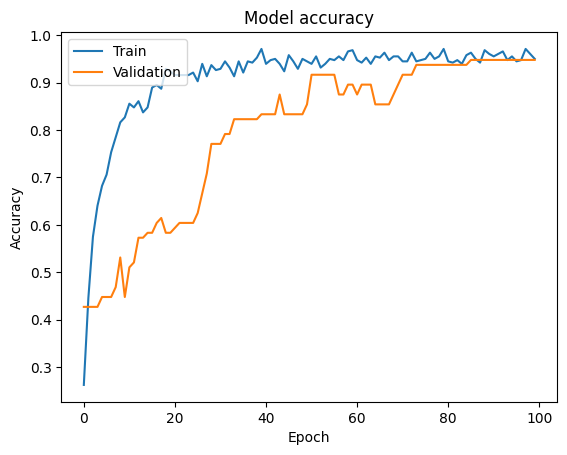

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_with_attention.history['accuracy'])
plt.plot(history_with_attention.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

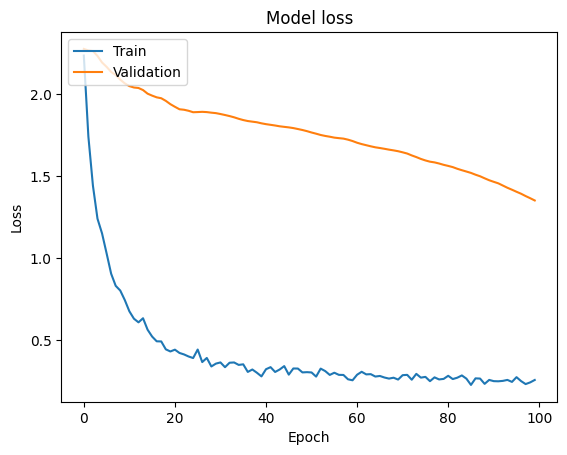

In [ ]:
# Plot training & validation loss values
plt.plot(history_with_attention.history['loss'])
plt.plot(history_with_attention.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step


<Figure size 1000x700 with 0 Axes>

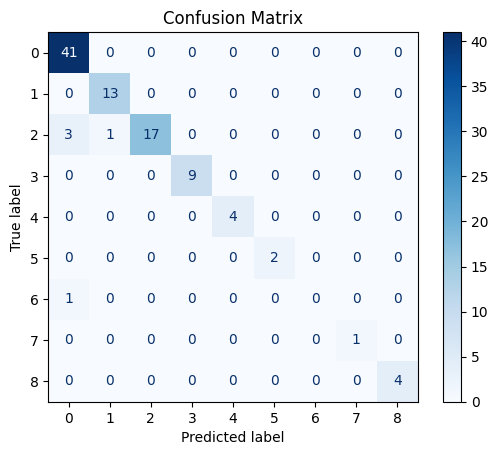

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the class probabilities for the test set
y_pred_prob = model_with_attention.predict([
    X_color_test, X_decor_test, X_lightning_test, X_furniture_test,
    X_styling_test, X_washing_test, X_waiting_test, age_test,
    gender_test, income_test
])
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes, labels=np.arange(num_clusters))

# Create a ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_clusters))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from keras.models import load_model

# Assuming `model_with_attention` is your trained model
model_with_attention.save('/content/drive/MyDrive/Final Research/model_with_attention.h5')


In [ ]:
import pickle
from keras.models import model_from_json

# Save the model architecture as JSON
model_json = model_with_attention.to_json()
with open('/content/drive/MyDrive/Final Research/newmodel_with_attention.json', 'w') as json_file:
    json_file.write(model_json)

# Save the model weights
model_with_attention.save_weights('/content/drive/MyDrive/Final Research/newmodel_with_attention_weights.weights.h5')

# Pickle the JSON and weights paths
model_data = {
    'json': '/content/drive/MyDrive/Final Research/newmodel_with_attention.json',
    'weights': '/content/drive/MyDrive/Final Research/newmodel_with_attention_weights.weights.h5'
}
with open('/content/drive/MyDrive/Final Research/newmodel_with_attention.pkl', 'wb') as pkl_file:
    pickle.dump(model_data, pkl_file)

In [ ]:
import numpy as np
import warnings
import os
from keras.models import load_model
from PIL import Image
import tensorflow as tf
from keras.layers import Layer

# Suppress TensorFlow warnings and logs
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Custom SelfAttention layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        attention_weights = tf.keras.layers.Softmax(axis=-1)(inputs)
        attention_output = inputs * attention_weights
        return attention_output

    def compute_output_shape(self, input_shape):
        return input_shape

# Load the trained model from the saved path
model_path = '/content/drive/MyDrive/Final Research/model_with_attention.h5'
model = load_model(model_path, custom_objects={'SelfAttention': SelfAttention})

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  # Resize to the target size (64, 64)
        image_array = np.array(image) / 255.0  # Normalize the image data
        if image_array.shape[-1] == 4:  # Handle RGBA (4 channels)
            image_array = image_array[..., :3]  # Convert to RGB
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        return image_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return np.zeros((1, target_size[0], target_size[1], 3))  # Return a dummy image if there's an error

# Example dictionary containing data
data = {
    'age': [18],  # Age of the customer
    'gender': [0],  # Gender of the customer (0 = Female, 1 = Male)
    'income_level': [1],  # Income level of the customer
    'color_image': ['/content/drive/MyDrive/ResearchImages/pastel.png'],
    'decor_image': ['/content/drive/MyDrive/ResearchImages/modernsaloon.jpeg'],
    'lightning_image': ['/content/drive/MyDrive/ResearchImages/Ambient.png'],
    'furniture_image': ['/content/drive/MyDrive/ResearchImages/CSSRAMP.jpg'],
    'styling_image': ['/content/drive/MyDrive/ResearchImages/mirrorchair.jpg'],
    'washing_image': ['/content/drive/MyDrive/ResearchImages/sinkshampoo1.jpg'],
    'waiting_image': ['/content/drive/MyDrive/ResearchImages/TvRefreshmentMagazine1.jpg']
}

# Extract demographic data
new_age = np.array([[data['age'][0]]])
new_gender = np.array([[data['gender'][0]]])
new_income = np.array([[data['income_level'][0]]])

# Load and preprocess images
new_X_color = load_and_preprocess_image(data['color_image'][0])
new_X_decor = load_and_preprocess_image(data['decor_image'][0])
new_X_lightning = load_and_preprocess_image(data['lightning_image'][0])
new_X_furniture = load_and_preprocess_image(data['furniture_image'][0])
new_X_styling = load_and_preprocess_image(data['styling_image'][0])
new_X_washing = load_and_preprocess_image(data['washing_image'][0])
new_X_waiting = load_and_preprocess_image(data['waiting_image'][0])

# Predict the cluster for the new data
try:
    predicted_cluster = model.predict([
        new_X_color, new_X_decor, new_X_lightning, new_X_furniture,
        new_X_styling, new_X_washing, new_X_waiting,
        new_age, new_gender, new_income
    ])
    # Get the predicted cluster label
    predicted_cluster_label = np.argmax(predicted_cluster, axis=1)
    print(f"Predicted cluster: {predicted_cluster_label}")
except Exception as e:
    print(f"Error during prediction: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted cluster: [2]


In [ ]:
import numpy as np
import warnings
import os
from keras.models import load_model
from PIL import Image
import tensorflow as tf
from keras.layers import Layer

# Suppress TensorFlow warnings and logs
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Custom SelfAttention layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        attention_weights = tf.keras.layers.Softmax(axis=-1)(inputs)
        attention_output = inputs * attention_weights
        return attention_output

    def compute_output_shape(self, input_shape):
        return input_shape

# Load the trained model from the saved path
model_path = '/content/drive/MyDrive/Final Research/model_with_attention.h5'
model = load_model(model_path, custom_objects={'SelfAttention': SelfAttention})

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  # Resize to the target size (64, 64)
        image_array = np.array(image) / 255.0  # Normalize the image data
        if image_array.shape[-1] == 4:  # Handle RGBA (4 channels)
            image_array = image_array[..., :3]  # Convert to RGB
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        return image_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return np.zeros((1, target_size[0], target_size[1], 3))  # Return a dummy image if there's an error

# Example dictionary containing data
data = {
    'age': [25],  # Age of the customer
    'gender': [0],  # Gender of the customer (0 = Female, 1 = Male)
    'income_level': [1],  # Income level of the customer
    'color_image': ['/content/drive/MyDrive/ResearchImages/pastel.png'],
    'decor_image': ['/content/drive/MyDrive/ResearchImages/modernsaloon.jpeg'],
    'lightning_image': ['/content/drive/MyDrive/ResearchImages/Ambient.png'],
    'furniture_image': ['/content/drive/MyDrive/ResearchImages/SCRAMP.jpg'],
    'styling_image': ['/content/drive/MyDrive/ResearchImages/DoubleSidedSalonMirror.png'],
    'washing_image': ['/content/drive/MyDrive/ResearchImages/sinkchairshampoo.jpg'],
    'waiting_image': ['/content/drive/MyDrive/ResearchImages/TVrefreshment.jpg']
}

# Extract demographic data
new_age = np.array([[data['age'][0]]])
new_gender = np.array([[data['gender'][0]]])
new_income = np.array([[data['income_level'][0]]])

# Load and preprocess images
new_X_color = load_and_preprocess_image(data['color_image'][0])
new_X_decor = load_and_preprocess_image(data['decor_image'][0])
new_X_lightning = load_and_preprocess_image(data['lightning_image'][0])
new_X_furniture = load_and_preprocess_image(data['furniture_image'][0])
new_X_styling = load_and_preprocess_image(data['styling_image'][0])
new_X_washing = load_and_preprocess_image(data['washing_image'][0])
new_X_waiting = load_and_preprocess_image(data['waiting_image'][0])

# Predict the cluster for the new data
try:
    predicted_cluster = model.predict([
        new_X_color, new_X_decor, new_X_lightning, new_X_furniture,
        new_X_styling, new_X_washing, new_X_waiting,
        new_age, new_gender, new_income
    ])
    # Get the predicted cluster label
    predicted_cluster_label = np.argmax(predicted_cluster, axis=1)
    print(f"Predicted cluster: {predicted_cluster_label}")
except Exception as e:
    print(f"Error during prediction: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
Predicted cluster: [0]


In [10]:
import pandas as pd

# Read the datasets
df1 = pd.read_csv('/content/drive/MyDrive/Final Research/salondataset.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Final Research/PP2_Preprocess_Final_dataset(9).csv')

# Select the 'Cluster' column from df2
df2_cluster = df2[['Cluster']]

# Merge df1 with df2_cluster
merged_df = pd.concat([df1, df2_cluster], axis=1)

# Write the merged dataset to a new CSV file
merged_df.to_csv('/content/drive/MyDrive/Final Research/merged_dataset.csv', index=False)

In [11]:
# Display the head of the merged dataset
print(merged_df.head())

       Age  Gender IncomeLevel  \
0  25 - 34  Female      middle   
1  18 - 24  Female      middle   
2  18 - 24  Female      middle   
3  25 - 34  Female      middle   
4  18 - 24    Male      middle   

                                               Color  \
0   /content/drive/MyDrive/ResearchImages/pastel.png   
1   /content/drive/MyDrive/ResearchImages/pastel.png   
2  /content/drive/MyDrive/ResearchImages/Monocrom...   
3  /content/drive/MyDrive/ResearchImages/Monocrom...   
4  /content/drive/MyDrive/ResearchImages/Neutral.png   

                                               Decor  \
0  /content/drive/MyDrive/ResearchImages/modernsa...   
1  /content/drive/MyDrive/ResearchImages/modernsa...   
2  /content/drive/MyDrive/ResearchImages/traditio...   
3  /content/drive/MyDrive/ResearchImages/modernsa...   
4  /content/drive/MyDrive/ResearchImages/modernsa...   

                                           Lightning  \
0  /content/drive/MyDrive/ResearchImages/Ambient.png   
1  /conte

In [12]:
# Group the merged dataset by 'Cluster', 'Age', 'Gender', and 'Income Level'
grouped_data = merged_df.groupby(['Cluster', 'Age', 'Gender', 'IncomeLevel'])

# Count the occurrences of each combination
count_per_combination = grouped_data.size().reset_index(name='Count')



# Display the counts for each combination
print(count_per_combination)

    Cluster      Age  Gender IncomeLevel  Count
0         0  25 - 34  Female      middle    153
1         0  25 - 34    Male      middle     45
2         1  45 - 54  Female      middle     27
3         1  45 - 54    Male      middle     18
4         2  18 - 24  Female      middle     99
5         2  18 - 24    Male      middle      9
6         3  35 - 44  Female      middle     36
7         3  35 - 44    Male      middle     36
8         4  25 - 34  Female         low     18
9         5  45 - 54    Male        High      9
10        6  18 - 24  Female         low      9
11        7  35 - 44    Male        High      9
12        8  25 - 34    Male        High      9


In [13]:
# Group the merged dataset by 'Cluster', 'Age', 'Gender', and 'IncomeLevel'
grouped_data = merged_df.groupby(['Cluster', 'Age', 'Gender', 'IncomeLevel']).size().reset_index(name='Count')

# Iterate over each cluster
for cluster, data in grouped_data.groupby('Cluster'):
    # Create custom labels for x-axis ticks
    custom_labels = data['Age'] + ' | ' + data['Gender'] + ' | ' + data['IncomeLevel']

    # Print cluster and corresponding combination information
    print(f"Cluster {cluster} represents:")
    for label in custom_labels:
        print(label)
    print()  # Add empty line for clarity

Cluster 0 represents:
25 - 34 | Female | middle
25 - 34 | Male | middle

Cluster 1 represents:
45 - 54 | Female | middle
45 - 54 | Male | middle

Cluster 2 represents:
18 - 24 | Female | middle
18 - 24 | Male | middle

Cluster 3 represents:
35 - 44 | Female | middle
35 - 44 | Male | middle

Cluster 4 represents:
25 - 34 | Female | low

Cluster 5 represents:
45 - 54 | Male | High

Cluster 6 represents:
18 - 24 | Female | low

Cluster 7 represents:
35 - 44 | Male | High

Cluster 8 represents:
25 - 34 | Male | High



<ipython-input-14-bef9d3271c01>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(set(clusters)))


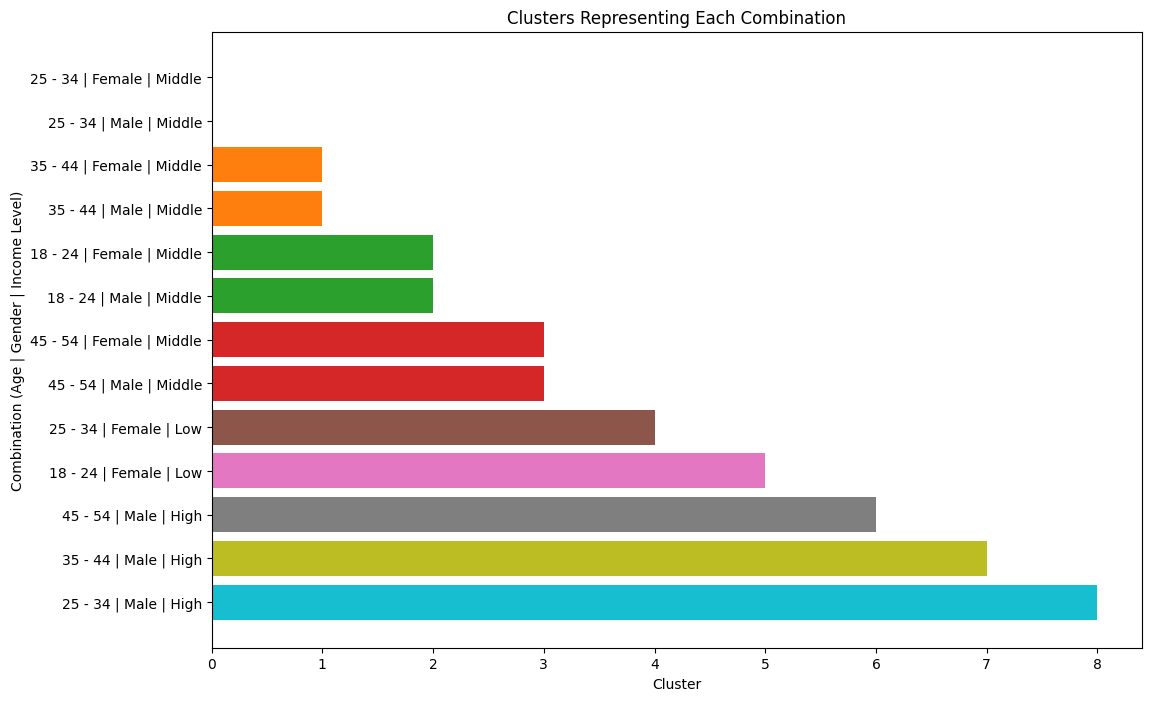

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define the combination information based on your clusters
combination_info = {
    '25 - 34 | Female | Middle': 0,
    '25 - 34 | Male | Middle': 0,
    '35 - 44 | Female | Middle': 1,
    '35 - 44 | Male | Middle': 1,
    '18 - 24 | Female | Middle': 2,
    '18 - 24 | Male | Middle': 2,
    '45 - 54 | Female | Middle': 3,
    '45 - 54 | Male | Middle': 3,
    '25 - 34 | Female | Low': 4,
    '18 - 24 | Female | Low': 5,
    '45 - 54 | Male | High': 6,
    '35 - 44 | Male | High': 7,
    '25 - 34 | Male | High': 8
}


# Convert the dictionary to lists for plotting
y_labels = list(combination_info.keys())
clusters = list(combination_info.values())

# Create a colormap with a unique color for each cluster
colors = plt.cm.get_cmap('tab10', len(set(clusters)))

# Create a horizontal bar plot with different colors for each combination
plt.figure(figsize=(12, 8))
bars = plt.barh(y_labels, clusters, color=[colors(cluster) for cluster in clusters])
plt.xlabel('Cluster')
plt.ylabel('Combination (Age | Gender | Income Level)')
plt.title('Clusters Representing Each Combination')
plt.gca().invert_yaxis()  # Invert y-axis to display combinations in the correct order

# Show the plot
plt.show()


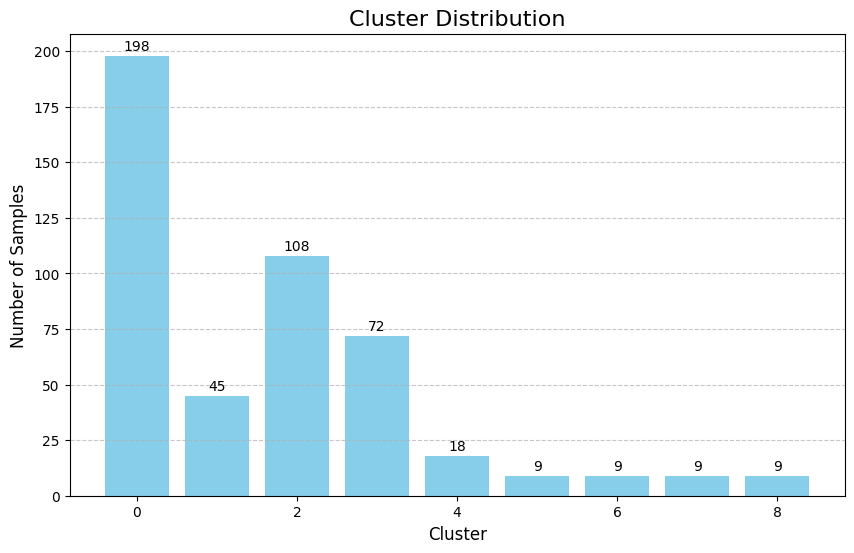

In [15]:
import matplotlib.pyplot as plt

# Cluster distribution with labeled bars
plt.figure(figsize=(10, 6))
cluster_counts = merged_df['Cluster'].value_counts().sort_index()
bars = plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')

# Add title, axis labels, and grid
plt.title('Cluster Distribution', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

plt.show()
